# TOTAL ENERGY FORECAST PROJECT

In [24]:
# Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read data
energy_df = pd.read_csv("../Data/total quarterly energy consumption.csv",
                       index_col='Quarter', parse_dates=True,
                       dayfirst=True)

In [3]:
# Perform EDA on the dataframe

energy_df.head()

,Total final consumption
Quarter,
1998-01-01,48479
1998-04-01,38544
1998-07-01,34412
1998-10-01,47223
1999-01-01,50346


In [4]:
energy_df.describe()

,Total final consumption
count,101.000000
mean,38957.316832
std,6900.569537
min,23805.000000
25%,33713.000000
50%,38598.000000
75%,44502.000000
max,52534.000000


In [5]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 1998-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Total final consumption  101 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


<AxesSubplot:xlabel='Quarter'>

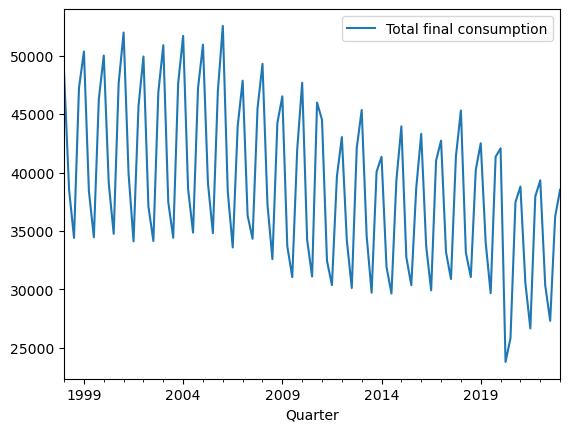

In [6]:
energy_df.plot()

In [7]:
# Create different functions to perform various tasks
# Perform Adulf Muller test 
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF: ", dftest[0])
    print("2. P-Value: ", dftest[1])
    print("3. Num of Lags: ", dftest[2])
    print("4. Num of Observations Used for ADF Regression: ", dftest[3])
    print("5. Critical values: ")
    for k,v in dftest[4].items():
        print(f"\t {k}: {v}")
        
# Plot Graph
def plot_graph(test, pred):
    plt.figure(figsize=(10,10))
    plt.plot(test, label = 'Testing')
    plt.plot(pred, label = 'Prediction')
    plt.legend(loc='upper right')
    plt.show()
    
# Calcultate prediction error
def calculate_error(data, prediction):
    mean = data.mean()
    rmse = sqrt(mean_squared_error(prediction,data))
    print("Root Mean Squared Error:",round(rmse,2))
    print("There is a ",round((rmse/mean)*100,2), "% error in the prediction")

In [29]:
# Split data
training_data = energy_df.iloc[:-25]
testing_data = energy_df.iloc[-25:]
print(training_data.shape, testing_data.shape)

(76, 1) (25, 1)


In [30]:
# Decompose the the dataframe to check each component
components = seasonal_decompose(energy_df,
                                    model = 'multiplicative', period = 4)

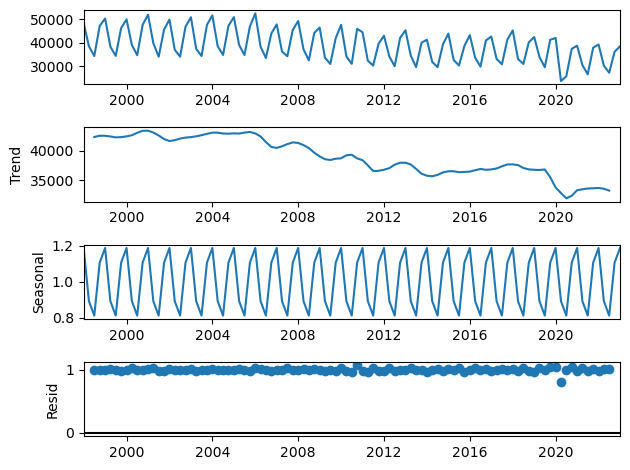

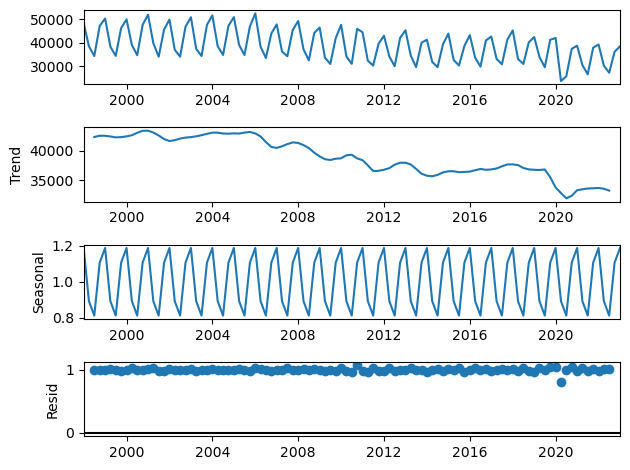

In [31]:
# Plot graph of each component
components.plot()

In [32]:
# Call the ad_test function to perform the Adulf Muller test
ad_test(energy_df)

1. ADF:  -0.3924174293927603
2. P-Value:  0.9113571179482988
3. Num of Lags:  13
4. Num of Observations Used for ADF Regression:  87
5. Critical values: 
	 1%: -3.5078527246648834
	 5%: -2.895382030636155
	 10%: -2.584823877658872


In [33]:
# Run the auto_arima function to see the best AIC
fit = auto_arima(training_data, m = 4, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=1283.136, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=1288.925, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=1280.857, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=1282.768, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=1288.707, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=1285.576, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=1281.931, Time=0.09 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=1282.315, Time=0.09 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=1281.464, Time=0.06 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=1283.640, Time=0.24 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=1290.622, Time=0.05 sec
 ARIMA(2,0,0)(1,1,0)[4] intercept   : AIC=1281.622, Time=0.10 sec
 ARIMA(1,0,1)(1,1,0)[4] intercept   : AIC=1279.195, Time=0.13 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=1287.354, Time=0.10 sec
 ARIMA(1,0,1)(2,1,0)[4] intercept

In [34]:
# We can then proceed to create the ARIMA model using the order (1,0,1)

arima_model = ARIMA(training_data, order = (1,0,1))
arima_model = arima_model.fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Total final consumption   No. Observations:                   76
Model:                      ARIMA(1, 0, 1)   Log Likelihood                -754.638
Date:                     Mon, 07 Aug 2023   AIC                           1517.276
Time:                             16:22:37   BIC                           1526.599
Sample:                         01-01-1998   HQIC                          1521.002
                              - 10-01-2016                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.02e+04   1187.268     33.859      0.000    3.79e+04    4.25e+04
ar.L1         -0.0231      0.159     -0.145      0.885      -0.335       0.289
ma.L1          0.9550      0.054     17.716      0.000       0.849       1.061
sigma2      2.391e+07      0.032   7.49e+08      0.000    2.39e+07    2.39e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.29
Prob(Q):                              0.87   Prob(JB):                         0.19
Heteroskedasticity (H):               0.79   Skew:                            -0.12
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.79e+25. Standard errors may be unstable.
"""

In [35]:
# Set the start amd end point for the prediction
start = len(training_data)
end = len(training_data)+len(testing_data)-1

prediction = pd.DataFrame(arima_model.predict(
    start = start, end = end, index = testing_data.index, typ='levels'))

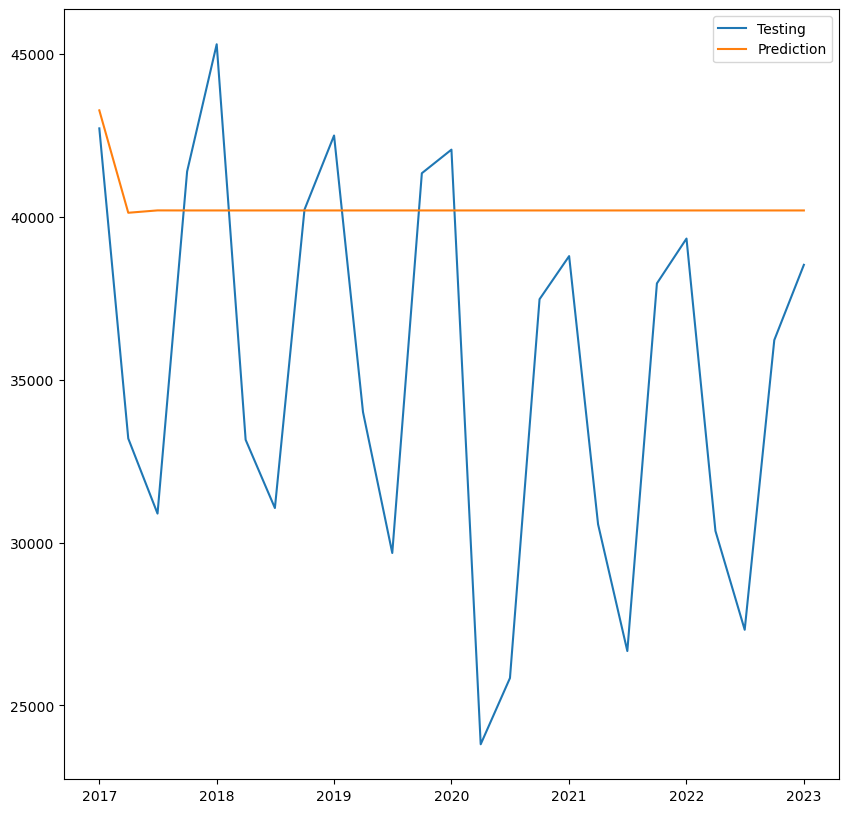

In [36]:
# Plot the prediction against the testing data
plot_graph(testing_data, prediction)

In [37]:
# Calculate error
calculate_error(testing_data['Total final consumption'], prediction)

Root Mean Squared Error: 7752.24
There is a  22.01 % error in the prediction


# Result
It is evident that the prediction is entirely wrong considering that the seasonality in the data was not handled before going ahead to make poredictions. We now use another method to handles seasonality for the forecast.

In [38]:
# Call on the STL function and fit on the dataframe
stl_components = STL(energy_df, seasonal = 13).fit()

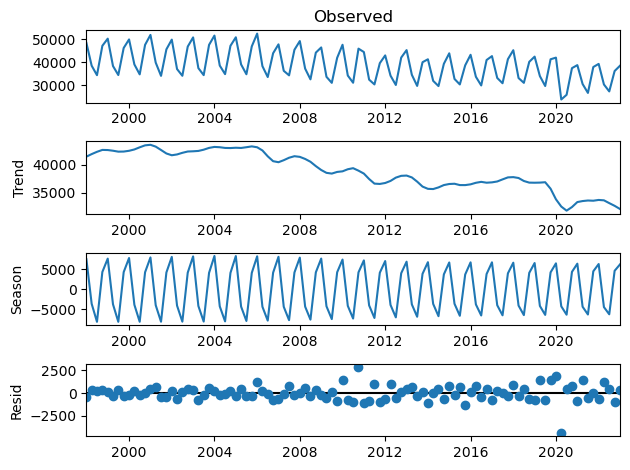

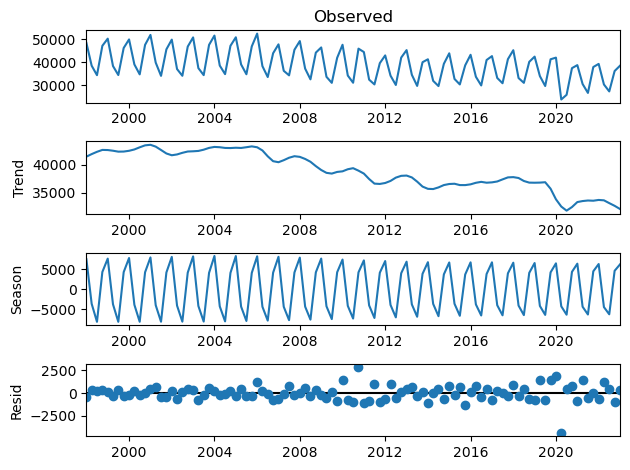

In [39]:
# Plot to take a look at each of the components
stl_components.plot()

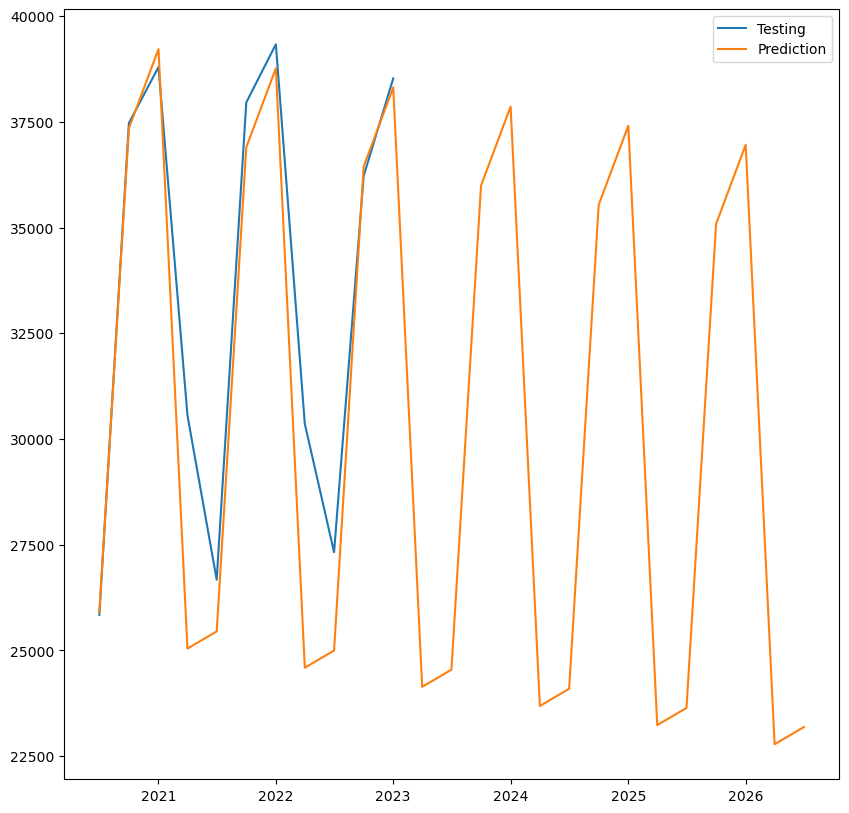

In [99]:
# Perform forecast on the 25 datapoints and compare against the testing data
stl_f = STLForecast(training_data, ARIMA, 
                           model_kwargs=dict(order=(1,0,1), trend='t')).fit()
stl_forecast = stl_f.forecast(25)
plot_graph(testing_data, stl_forecast)

In [43]:
# Check the percentage error in the forecasr
calculate_error(testing_data['Total final consumption'], stl_forecast)

Root Mean Squared Error: 2972.51
There is a  8.44 % error in the prediction


# Result
It is evident thaat forecasting using STL performs better looking at the graph and the percentage error in the prediction. We can now try to use other methods and see if there is a further reduction in the percentage error in the model.

In [48]:
# Call on the sarimax model and specify the AIC orders
model_sarimax = SARIMAX(training_data, order=(1,0,1), 
                        seasonal_order=(0,1,1,4), enforce_stationarity=False).fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74692D+00    |proj g|=  7.92382D-01

At iterate    5    f=  7.59342D+00    |proj g|=  3.05316D-02

At iterate   10    f=  7.59312D+00    |proj g|=  1.53963D-04

At iterate   15    f=  7.59309D+00    |proj g|=  4.35359D-03

At iterate   20    f=  7.58926D+00    |proj g|=  6.97596D-02

At iterate   25    f=  7.57131D+00    |proj g|=  1.99271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   

 This problem is unconstrained.


In [49]:
# Perform prediction
pred = pd.DataFrame(model_sarimax.predict(
    start = start, end = end, index = testing_data.index, typ='levels'))

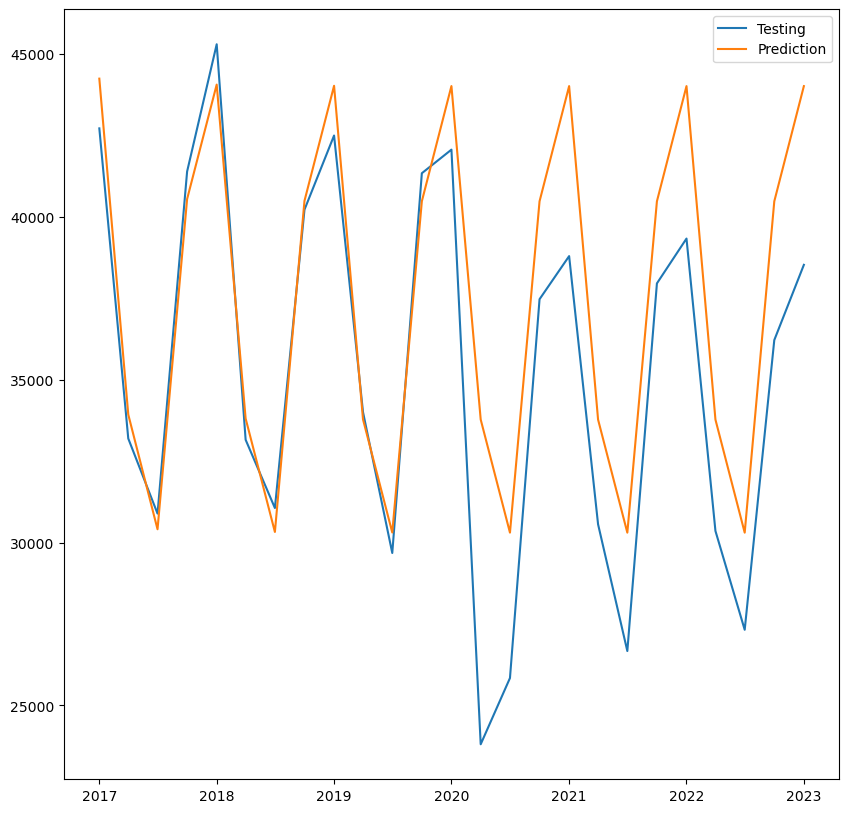

In [50]:
# Plot the graph of the prediction against the testing data
plot_graph(testing_data, pred)

In [51]:
calculate_error(testing_data['Total final consumption'], pred)

Root Mean Squared Error: 3406.8
There is a  9.67 % error in the prediction


# Result
From thr percentage error obtained, we can see that the STL Forecast performed better than the SARIMAX model. We can further add various explanatory variables to the SARIMAX model to see if that helps us improve the model performance.

In [54]:
# Read in the gdp data
gdp = pd.read_csv('../Data/UK_gdp.csv', index_col='Quarter', 
                  parse_dates=True, dayfirst=True)

In [56]:
# Check the first few lines of the data
gdp.head()

,gdp,adjusted_gdp
Quarter,,
1998-01-01,0.6,67.3
1998-04-01,0.5,67.7
1998-07-01,0.3,67.9
1998-10-01,0.6,68.3
1999-01-01,0.7,68.8


In [57]:
gdp.describe()

,gdp,adjusted_gdp
count,101.000000,101.000000
mean,0.431683,85.568317
std,2.830439,9.323454
min,-21.000000,67.300000
25%,0.200000,79.300000
50%,0.500000,84.900000
75%,0.800000,93.300000
max,16.600000,100.300000


In [58]:
# Drop the adjusted gdp column as it is not relevant
gdp.drop(columns='adjusted_gdp', inplace=True, axis=1)

In [60]:
# Split the gdp data into training and testing set ensuring the shape matches the training and testing sets that were previously done
gdp_train = gdp.iloc[:-25]
gdp_test = gdp.iloc[-25:]

In [61]:
# Call on the SARIMAX model, adding the gdp_train as an explanatory variable
model_sarimax2 = SARIMAX(training_data, exog=gdp_train['gdp'], order=(1,0,1), 
                        seasonal_order=(0,1,1,4), enforce_stationarity=False,
                        enforce_invertibility=False).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74692D+00    |proj g|=  1.45343D+00

At iterate    5    f=  7.59601D+00    |proj g|=  3.82322D-02

At iterate   10    f=  7.59305D+00    |proj g|=  1.38877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   1.389D-04   7.593D+00
  F =   7.5930523070582323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [62]:
# Check the summary of the model
print(model_sarimax2.summary())

                                     SARIMAX Results                                     
Dep. Variable:           Total final consumption   No. Observations:                   76
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 4)   Log Likelihood                -577.072
Date:                           Mon, 07 Aug 2023   AIC                           1164.144
Time:                                   16:31:01   BIC                           1175.092
Sample:                               01-01-1998   HQIC                          1168.470
                                    - 10-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gdp           -1.7103    479.346     -0.004      0.997    -941.211     937.790
ar.L1          0.6663      0.192      3.479

In [63]:
# Perform prediction
gdp_pred = pd.DataFrame(model_sarimax2.predict(
    start = start, end = end, index = testing_data.index, exog=gdp_test['gdp']))

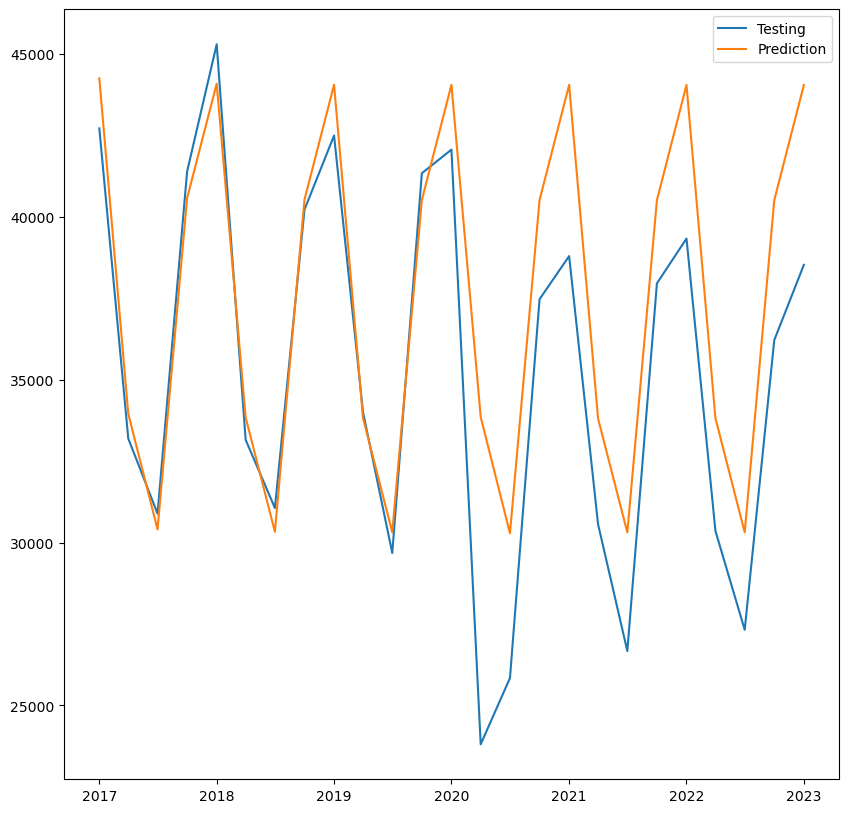

In [64]:
# Plot the graph
plot_graph(testing_data, gdp_pred)

In [65]:
# Calculate the error in the prediction
calculate_error(testing_data['Total final consumption'], gdp_pred)

Root Mean Squared Error: 3430.38
There is a  9.74 % error in the prediction


# Result
From the percentage error obtained, we can see that the error is even higher with the GDP data added as the explanatory variable. The sharp decrease in consumption between mid 2019 and earlier parts of 2020 was due to a phenomenal event that occured, which was COVID. Most of the data available do not cater for that.

The next step is to create a dummy covid that where the quarters without covid are denoted by 0s and the quarters when covid was in the UK are denoted with 1s. We can then perform the performance of the model and compare the percentage error.

P.S: The training data will have to be increased so that the model is trained with some parts where the covid variables are 1s.

In [73]:
covid = pd.read_csv('../Data/covid_endog.csv', index_col='Quarter', 
                    parse_dates=True, dayfirst=True)

In [74]:
covid.tail(25)

,Covid
Quarter,
2017-01-01,0
2017-04-01,0
2017-07-01,0
2017-10-01,0
2018-01-01,0
2018-04-01,0
2018-07-01,0
2018-10-01,0
2019-01-01,0


In [85]:
# Split data so that the covid datapoints are included in the training data
training_data = energy_df.iloc[:-11]
testing_data = energy_df.iloc[-11:]

covid_exog_train = covid[:-11]
covid_exog_test = covid[-11:]

# Check to confirm the shapes of the split data
print(training_data.shape, testing_data.shape)
print(covid_exog_train.shape, covid_exog_test.shape)

# Adjust the start and end points for the prediction
start = len(training_data)
end = len(training_data)+len(testing_data)-1
print(start, end)

(90, 1) (11, 1)
(90, 1) (11, 1)
90 100


In [86]:
# Call on the SARIXMAX model with the covid data as the explanatory variable
model_sarimax3 = SARIMAX(training_data, exog=covid_exog_train['Covid'], order=(1,0,1), 
                        seasonal_order=(0,1,1,4), enforce_stationarity=False,
                        enforce_invertibility=False).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18264D+00    |proj g|=  2.47877D+00

At iterate    5    f=  7.87127D+00    |proj g|=  5.01106D-02

At iterate   10    f=  7.86364D+00    |proj g|=  2.63013D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.151D-04   7.864D+00
  F =   7.8636381844460095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [87]:
# Perform predictions
covid_pred = pd.DataFrame(model_sarimax3.predict(
        start = start, end = end, index = testing_data.index, exog=covid_exog_test['Covid']))

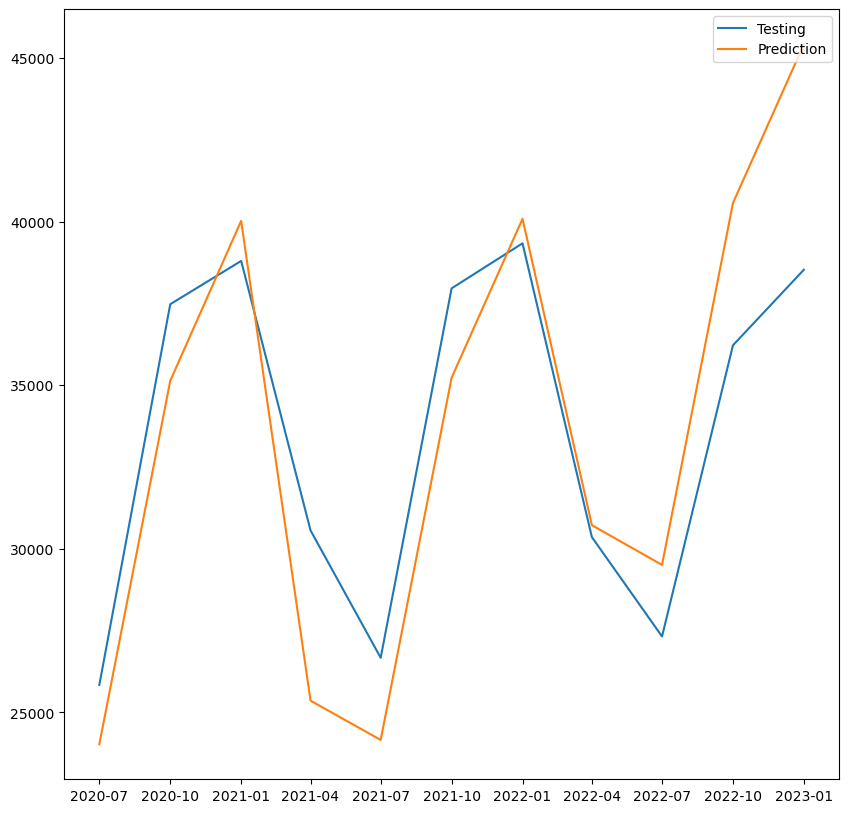

In [88]:
# Plot the graph to compare the prediction to the testing data
plot_graph(testing_data, covid_pred)

In [90]:
# Calculate the percentage error
calculate_error(testing_data['Total final consumption'], covid_pred)

Root Mean Squared Error: 3343.45
There is a  9.97 % error in the prediction


# Result
With the added covid datapoints as the explanatory variable, we can observe that there is no major improvement to the model. So far, the best forecast with the least error was obtained using the STL forecast model. We can then perform future forecast with this.

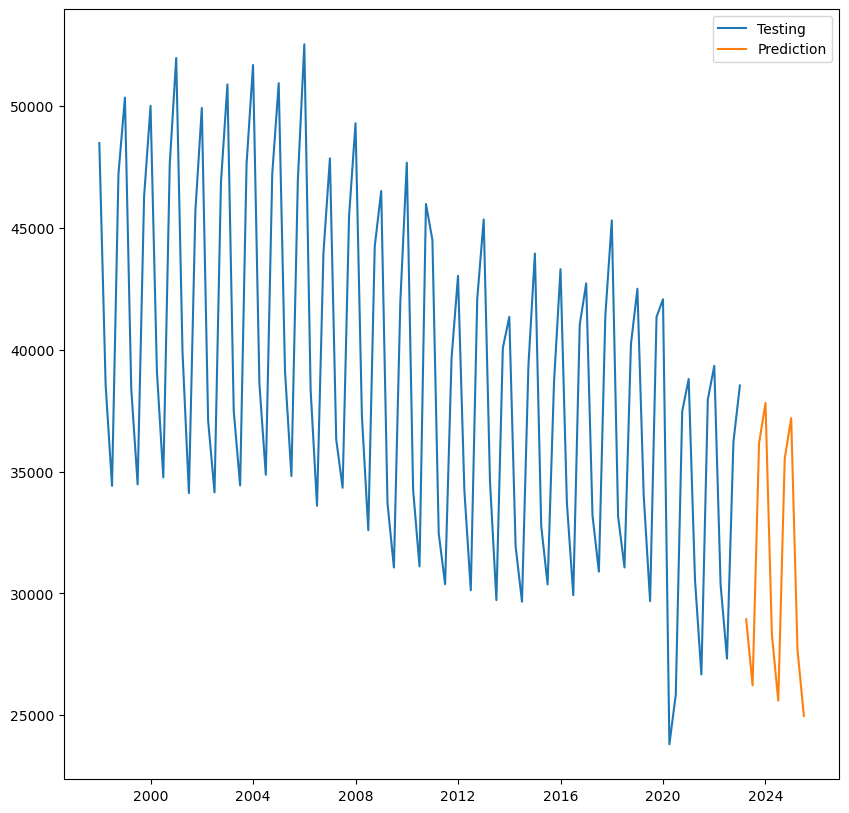

In [104]:
# Forecast for the next 10 quarters
stl_full = STLForecast(energy_df, ARIMA, 
                           model_kwargs=dict(order=(1,0,1), trend='t')).fit()
stl_forecast_full = stl_full.forecast(10)
plot_graph(energy_df, stl_forecast_full)

In [93]:
# Split the gdp data into training and testing set ensuring the shape matches the training and testing sets that were previously done
gdp_train = gdp.iloc[:-11]
gdp_test = gdp.iloc[-11:]

In [98]:
print(training_data.shape)
print(covid_exog_train.shape)
print(gdp_train.shape)

(90, 1)
(90, 1)
(90, 1)


In [95]:
model_sarimax4 = SARIMAX(endog=training_data, exog=[gdp_train, covid_exog_train], order=(1,0,1), 
                        seasonal_order=(0,1,1,4), enforce_stationarity=False,
                        enforce_invertibility=False).fit()

ValueError: exog is not 1d or 2d